# Evolution of endolysins by vertical evolution

In [1]:
import csv
from IPython.display import clear_output
import itertools
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import mysql.connector
import numpy as np
import pandas as pd
import pickle
import seaborn as sb
from scipy.cluster.hierarchy import linkage, to_tree, fcluster

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format("#" * block + "-" * (bar_length - block), progress * 100)
    print(text)
    
user = 'xxxx' # fill in MySQL user
password = 'xxxx' # fill in MySQL pw
db = 'xxxx' # fill in MySQL database name
socket = '/x/x/x/x.sock' # fill in MySQL unix socket

## Get PhaLPs

In [2]:
cnx = mysql.connector.connect(user=user, password=password, database=db, unix_socket=socket)
cursor = cnx.cursor()
cursor.execute("SELECT DISTINCT(UniProt_ID), type, type_evidence, type_probability FROM UniProt;")

up_acc = []
types = []
type_evidence = []
type_probability = []
for i in cursor:
    up_acc.append(i[0])
    types.append(i[1])
    type_evidence.append(i[2])
    type_probability.append(i[3])
tmp = {'type' : types, 'type_evidence' : type_evidence, 'type_probability' : type_probability}
main_table = pd.DataFrame(tmp, index=up_acc)

In [3]:
### set confidence level threshold for protein typing
endolysins = [i for i in main_table.index if main_table.loc[i, 'type'] == 'endolysin' and main_table.loc[i, 'type_probability'] >= 75]
vals = [i for i in main_table.index if main_table.loc[i, 'type'] == 'VAL' and main_table.loc[i, 'type_probability'] >= 75]
unclass = [i for i in main_table.index if i not in endolysins and i not in vals]

In [4]:
### VAL vs endolysin sequences
cnx = mysql.connector.connect(user=user, password=password, database=db, unix_socket=socket)

cursor = cnx.cursor()
cursor.execute("SELECT ur.protein_sequence, up.UniProt_ID FROM UniProt as up JOIN UniRef as ur WHERE up.UniRef_ID = ur.UniRef_ID;")

endolysin_seqs = []
val_seqs = []
acc2seq = {}
seq2acc = {}
for i in cursor:
    if i[1] in endolysins:
        endolysin_seqs.append(i[0])
    elif i[1] in vals:
        val_seqs.append(i[0])
    
    if i[0] in seq2acc:
        seq2acc[i[0]].append(i[1])
    else:
        seq2acc[i[0]] = [i[1]]
    acc2seq[i[1]] = i[0]
    
print("Amount of unique uniprot accessions: ")
print(len(set(acc2seq.keys())))
print("Amount of unique protein sequences: ")
print(len(seq2acc.keys()))

Amount of unique uniprot accessions: 
11838
Amount of unique protein sequences: 
7957


In [5]:
duplicates = [v for k,v in seq2acc.items() if len(v) > 1]
print('There are', len(duplicates), 'sequences that are linked to more than one uniprot ID.')

There are 1366 sequences that are linked to more than one uniprot ID.


In [6]:
seqs_ordered = []
accs_ordered = []
for i in seq2acc:
    seqs_ordered.append(i)
    accs_ordered.append(seq2acc[i])
print(len(seqs_ordered), len(accs_ordered))

7957 7957


In [8]:
### write out to csv
with open('PhaLP_unique_seqs.csv', 'w+') as myfile:
    wr = csv.writer(myfile)
    for i in seqs_ordered:
        wr.writerow([i,])

## Alignments in Julia

Create similarity matrix by pairwise local alignments in julia: *alignments_julia.jl*

## Similarity Clustering

### Load-in & Normalisation

In [16]:
### Load in similarity matrix
sim_matrix = np.loadtxt(open("similarity_matrix_010121.csv", "rb"), delimiter=",")

### filter on endolysin indexes
nonendo = tuple([idx for idx, i in enumerate(accs_ordered) if len(set(i).intersection(set(endolysins))) == 0])
sim_matrix = np.delete(sim_matrix, nonendo, axis = 0)
sim_matrix = np.delete(sim_matrix, nonendo, axis = 1)
print(np.shape(sim_matrix))

### Normalize matrix 
sim_normalised = np.zeros(np.shape(sim_matrix))
for idx in range(len(sim_matrix)):
    for jdx in range(len(sim_matrix)):
        sim_normalised[idx, jdx] = round(sim_matrix[idx, jdx] /np.sqrt(sim_matrix[jdx, jdx]*sim_matrix[idx, idx]), 6)
        
sim_out = open("sim.pickle","wb")
pickle.dump(sim_normalised, sim_out)
sim_out.close()

(4515, 4515)


In [7]:
### filter on endolysin indexes
accs_ordered = [i for i in accs_ordered if len(set(i).intersection(set(endolysins))) != 0]
names_ordered = [list(set(i).intersection(set(endolysins)))[0] for i in accs_ordered]
print(len(accs_ordered))

4515


In [10]:
sim_in = open("sim.pickle","rb")
sim_normalised = pickle.load(sim_in)
#np.shape(sim_normalised)

sim_norm_df = pd.DataFrame(sim_normalised, columns=names_ordered, index=names_ordered)
sim_norm_df

,P20331,Q859T2,Q859R5,M1E3L7,A0A4D6AFV4,A0A4D6AJE2,A0A4D6AGL0,A0A0A7RUN1,Q0PRU8,A0A385IRL8,...,A0A516KUE5,A0A516KTN2,A0A516KSD2,A0A510E8H5,A0A516KPP4,A0A516KR10,A0A516KPH5,A0A516KU21,A0A516KV17,A0A513QBR4
P20331,1.000000,0.034887,0.027591,0.051979,0.027436,0.027246,0.023424,0.028059,0.034649,0.026395,...,0.017968,0.018000,0.025977,0.036456,0.022896,0.033649,0.034507,0.025880,0.021528,0.025051
Q859T2,0.034887,1.000000,0.026969,0.032230,0.028320,0.023302,0.023265,0.019998,0.021276,0.028218,...,0.022198,0.019793,0.018709,0.026256,0.028360,0.026239,0.022134,0.027668,0.021358,0.020493
Q859R5,0.027591,0.026969,1.000000,0.033150,0.025643,0.017497,0.018673,0.023860,0.016998,0.024799,...,0.021752,0.017937,0.021254,0.022179,0.022658,0.025247,0.020631,0.023210,0.022653,0.041677
M1E3L7,0.051979,0.032230,0.033150,1.000000,0.033816,0.023869,0.028597,0.040314,0.025218,0.030722,...,0.025886,0.025006,0.027310,0.031266,0.023240,0.027051,0.021766,0.030608,0.033495,0.030915
A0A4D6AFV4,0.027436,0.028320,0.025643,0.033816,1.000000,0.305273,0.294369,0.025771,0.020400,0.080087,...,0.029033,0.017713,0.021976,0.025700,0.019941,0.024997,0.023109,0.038791,0.022409,0.021674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A0A516KR10,0.033649,0.026239,0.025247,0.027051,0.024997,0.020603,0.018149,0.023215,0.044814,0.027926,...,0.019715,0.021618,0.111657,0.026884,0.024653,1.000000,0.025556,0.455866,0.022752,0.028777
A0A516KPH5,0.034507,0.022134,0.020631,0.021766,0.023109,0.021128,0.021093,0.022193,0.034722,0.026973,...,0.018113,0.072681,0.018607,0.021425,0.025897,0.025556,1.000000,0.027093,0.334736,0.020523
A0A516KU21,0.025880,0.027668,0.023210,0.030608,0.038791,0.021788,0.034277,0.028558,0.045729,0.026316,...,0.020900,0.025798,0.100191,0.030967,0.025484,0.455866,0.027093,1.000000,0.021785,0.038957
A0A516KV17,0.021528,0.021358,0.022653,0.033495,0.022409,0.017399,0.017371,0.018896,0.051989,0.019701,...,0.027817,0.088225,0.017621,0.022055,0.024200,0.022752,0.334736,0.021785,1.000000,0.018969


## Get host & phage annotation

In [11]:
host_df = pd.DataFrame(columns=['UniProt_ID', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species'])
for i in list(itertools.chain.from_iterable(accs_ordered)):
    cnx = mysql.connector.connect(user=user, password=password, database=db, unix_socket=socket)
    cursor = cnx.cursor()
    cursor.execute("SELECT up.UniProt_ID, h.lineage_phylum, h.lineage_class, h.lineage_order, h.lineage_family, h.lineage_genus, h.lineage_species FROM UniProt as up JOIN link_phage_host as l JOIN hosts as h WHERE up.UniProt_ID = '" + i + "' AND up.phages_ID = l.phages_ID AND l.hosts_ID = h.hosts_ID;")
    for j in cursor:
        row = pd.DataFrame(index = [0], columns=['UniProt_ID', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species'])
        row.iloc[0]['UniProt_ID'] = j[0]
        row.iloc[0]['Phylum'] = j[1]
        row.iloc[0]['Class'] = j[2]
        row.iloc[0]['Order'] = j[3]
        row.iloc[0]['Family'] = j[4]
        row.iloc[0]['Genus'] = j[5]
        row.iloc[0]['Species'] = j[6]
        host_df = host_df.append(row, ignore_index=True)

In [12]:
for i in host_df.index:
    if host_df.loc[i]['Order'] in ['Synechococcales', 'Nostocales', 'Oscillatoriales', 'Chroococcales']:
        host_df.loc[i]['Class'] = 'Cyanophyceae' 
    elif host_df.loc[i]['Genus'] == 'Plesiomonas':
        host_df.loc[i]['Family'] = 'Enterobacteriaceae'
    elif host_df.loc[i]['Genus'] == 'Exiguobacterium':
        host_df.loc[i]['Family'] = 'Bacillaceae'
host_df['Species'].replace('bacterium', None)
host_df = host_df.fillna('Unknown')
host_df.to_pickle('host_df.pickle')

In [13]:
### check accessions without annotated host
c = 0
for i in list(itertools.chain.from_iterable(accs_ordered)):
    if all(host_df[host_df.UniProt_ID == i].Species == 'Unknown'):
        c += 1
print(len(list(itertools.chain.from_iterable(accs_ordered)))-c, 'accessions with known hosts')

6563 accessions with known hosts


## Get architectures

In [17]:
acc2doms = {}
with open('simplified_architectures.csv', mode='r') as file:
    reader = csv.reader(file)
    for row in reader:
        acc2doms[row[0]] = [i for idx, i in enumerate(row) if idx != 0 and i != '']

## Clustering

In [18]:
row_linkage = linkage(np.asarray(sim_norm_df), method='average') # = Z
col_linkage = linkage(np.asarray(sim_norm_df).T, method='average')

<Figure size 576x576 with 0 Axes>

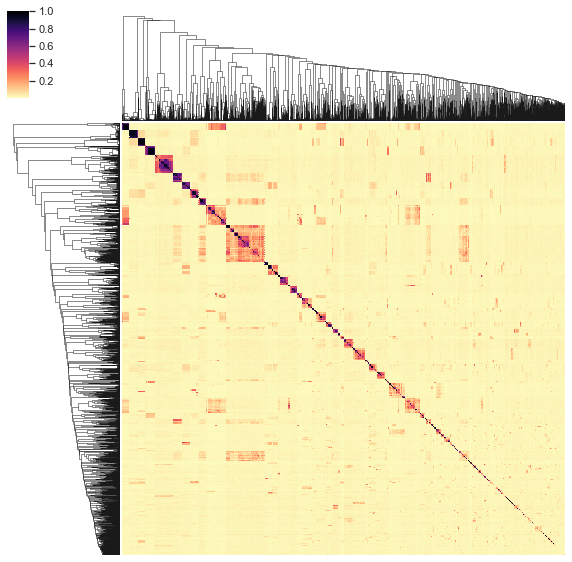

In [19]:
fig = plt.figure(figsize=(8, 8))
sb.set(font_scale=1)
plot = sb.clustermap(sim_norm_df, row_linkage=row_linkage, col_linkage=col_linkage, 
                     cmap='magma_r', xticklabels=False, yticklabels=False)
plt.savefig('PLOS_clustermap.png', format='png', dpi=600)
plt.show()

In [20]:
reordered_sim_df = sim_norm_df.iloc[plot.dendrogram_col.reordered_ind, plot.dendrogram_col.reordered_ind]
f = open('reordered_sim_mat.pkl','wb')
pickle.dump(reordered_sim_df, f)
f.close()

In [2]:
import pickle
f = open('reordered_sim_mat.pkl','rb')
reordered_sim_df = pickle.load(f)
f.close()

In [3]:
reordered_sim_df

,A0A0K2CLB2,W8FPK3,A0A411BRR3,A0A1B1PCT5,A0A345KKQ5,A0A0A7RUU1,A0A515MM52,A0A2P1N3B0,B3VGP8,G8I5V5,...,A0A2K9V2U2,H7BUU5,H7BV73,Q9FZW2,A0A2Z4GUC1,A0A1P8VV77,A0A0U4JCL8,F0PIL0,Q7Y3F1,A0A4D6DSD5
A0A0K2CLB2,1.000000,0.919371,0.922843,0.921485,0.937948,0.938727,0.939895,0.933068,0.932679,0.932679,...,0.014517,0.016265,0.018304,0.013265,0.014349,0.015890,0.020720,0.014787,0.017196,0.015846
W8FPK3,0.919371,1.000000,0.985300,0.962704,0.978760,0.975635,0.976807,0.978172,0.977781,0.977781,...,0.012317,0.016309,0.019088,0.013301,0.013952,0.016692,0.021270,0.014437,0.017243,0.018214
A0A411BRR3,0.922843,0.985300,1.000000,0.971310,0.980322,0.981103,0.982275,0.982859,0.982469,0.982469,...,0.014183,0.016309,0.018354,0.013301,0.016132,0.017451,0.021270,0.016778,0.017243,0.018214
A0A1B1PCT5,0.921485,0.962704,0.971310,1.000000,0.979464,0.981439,0.981439,0.982027,0.981632,0.981632,...,0.013210,0.016492,0.018559,0.013450,0.014108,0.018030,0.021509,0.014993,0.016644,0.018810
A0A345KKQ5,0.937948,0.978760,0.980322,0.979464,1.000000,0.996845,0.998028,0.995070,0.994676,0.994676,...,0.012435,0.016466,0.018530,0.013429,0.014086,0.016852,0.021475,0.014969,0.017409,0.018389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A0A1P8VV77,0.015890,0.016692,0.017451,0.018030,0.016852,0.017235,0.017235,0.016856,0.016473,0.016473,...,0.014275,0.013195,0.020518,0.017391,0.012827,1.000000,0.016978,0.012627,0.015372,0.016721
A0A0U4JCL8,0.020720,0.021270,0.021270,0.021509,0.021475,0.021475,0.021475,0.021479,0.021479,0.021479,...,0.014318,0.018248,0.015959,0.033448,0.016168,0.016978,1.000000,0.020955,0.017538,0.022298
F0PIL0,0.014787,0.014437,0.016778,0.014993,0.014969,0.014969,0.014969,0.014972,0.013790,0.014972,...,0.017317,0.019328,0.019993,0.020123,0.030343,0.012627,0.020955,1.000000,0.038736,0.128594
Q7Y3F1,0.017196,0.017243,0.017243,0.016644,0.017409,0.017409,0.017409,0.017412,0.017412,0.017412,...,0.018527,0.016934,0.014130,0.019762,0.015459,0.015372,0.017538,0.038736,1.000000,0.243391


## Full write-out

In [22]:
### normalized similarity matrix
reordered_sim_df.to_csv('Clusteranalysis_data.csv', index=False, header=False)

### accession metadata
acc_metadata_df = pd.DataFrame(index=np.arange(1, len(list(itertools.chain.from_iterable(accs_ordered)))+1),
                               columns=['Index', 'Accession', 'Type', 'Architecture', 'Host phylum', 
                                        'Host class', 'Host order', 'Host family', 'Host genus', 
                                        'Host species', 'url', 'Diagonal score'])
c = 1
for idx, i in enumerate(accs_ordered):
    for j in accs_ordered[idx]:
        acc_metadata_df.loc[c]['Index'] = idx + 1
        acc_metadata_df.loc[c]['Accession'] = j
        acc_metadata_df.loc[c]['Type'] = types[idx]
        if j in acc2doms:
            acc_metadata_df.loc[c]['Architecture'] = acc2doms[j]
        else:
            acc_metadata_df.loc[c]['Architecture'] = 'Unknown'
        if len(host_df[host_df.UniProt_ID == j]) == 0:
            acc_metadata_df.loc[c]['Host phylum'] = 'Unknown'
            acc_metadata_df.loc[c]['Host class'] = 'Unknown'
            acc_metadata_df.loc[c]['Host order'] = 'Unknown'
            acc_metadata_df.loc[c]['Host family'] = 'Unknown'
            acc_metadata_df.loc[c]['Host genus'] = 'Unknown'
            acc_metadata_df.loc[c]['Host species'] = 'Unknown'
        else:
            acc_metadata_df.loc[c]['Host phylum'] = list(host_df.Phylum[host_df.UniProt_ID == j])[0]
            acc_metadata_df.loc[c]['Host class'] = list(host_df.Class[host_df.UniProt_ID == j])[0]
            acc_metadata_df.loc[c]['Host order'] = list(host_df.Order[host_df.UniProt_ID == j])[0]
            acc_metadata_df.loc[c]['Host family'] = list(host_df.Family[host_df.UniProt_ID == j])[0]
            acc_metadata_df.loc[c]['Host genus'] = list(host_df.Genus[host_df.UniProt_ID == j])[0]
            acc_metadata_df.loc[c]['Host species'] = list(host_df.Species[host_df.UniProt_ID == j])[0]
        acc_metadata_df.loc[c]['Diagonal score'] = reordered_sim_df.iloc[idx][idx]
        acc_metadata_df.loc[c]['url'] = 'http://www.phalp.org/database/' + j + ' '
        c += 1
acc_metadata_df.to_csv('Clusteranalysis_metadata.csv', index=False, header=True)

## Examination of individual clusters

In [55]:
def cluster_writeout(cluster_ID, cutoff, reordered_sim_df, Z, accs_ordered, acc2doms, host_df):
    ### Get cluster divisions
    clust_assignments = fcluster(Z, 45, criterion='maxclust')
    
    ### Get individual cluster data
    accessions_in_cluster = sim_norm_df.columns[clust_assignments == cluster_ID]
    start = min([list(reordered_sim_df.columns).index(i) for i in accessions_in_cluster])
    stop = max([list(reordered_sim_df.columns).index(i) for i in accessions_in_cluster])
    
    ### Write individual cluster summaries to csv
    cluster_df = pd.DataFrame(index=np.arange(len(accessions_in_cluster)), 
                              columns=['Accession', 'Index', 'Type', 'Architecture', 'Host phylum', 'Host class', 
                                       'Host order', 'Host family', 'Host genus', 'Host species'])
    for idx, i in enumerate(accessions_in_cluster):
        cluster_df.loc[idx]['Accession'] = 'http://www.phalp.org/database/' + i + ' '
        #if i in accessions_in_cluster:
        index = start + list(accessions_in_cluster).index(i) #store index for all accessions with equal sequences
        cluster_df.loc[idx]['Index'] = index   
        
        if i in endolysins:
            cluster_df.loc[idx]['Type'] = 'Endolysin'
        elif i in vals:
            cluster_df.loc[idx]['Type'] = 'VAL'
        else:
            cluster_df.loc[idx]['Type'] = 'Unclassified'
            
        if i in acc2doms:
            cluster_df.loc[idx]['Architecture'] = acc2doms[i]
        else:
            cluster_df.loc[idx]['Architecture'] = 'Unknown'
            
        if len(host_df[host_df.UniProt_ID == i]) == 0:
            cluster_df.loc[idx]['Host phylum'] = 'Unknown'
            cluster_df.loc[idx]['Host class'] = 'Unknown'
            cluster_df.loc[idx]['Host order'] = 'Unknown'
            cluster_df.loc[idx]['Host family'] = 'Unknown'
            cluster_df.loc[idx]['Host genus'] = 'Unknown'
            cluster_df.loc[idx]['Host species'] = 'Unknown'
        else:
            cluster_df.loc[idx]['Host phylum'] = list(host_df.Phylum[host_df.UniProt_ID == i])[0]
            cluster_df.loc[idx]['Host class'] = list(host_df.Class[host_df.UniProt_ID == i])[0]
            cluster_df.loc[idx]['Host order'] = list(host_df.Order[host_df.UniProt_ID == i])[0]
            cluster_df.loc[idx]['Host family'] = list(host_df.Family[host_df.UniProt_ID == i])[0]
            cluster_df.loc[idx]['Host genus'] = list(host_df.Genus[host_df.UniProt_ID == i])[0]
            cluster_df.loc[idx]['Host species'] = list(host_df.Species[host_df.UniProt_ID == i])[0]
    
    filename = "clusters/cluster_" + str(cluster_ID) + "_summary.csv"
    cluster_df.to_csv(filename, header=True, index=True)

    
    ### Extract cluster heatmap to png
    filename = "clusters/cluster_" + str(cluster_ID) + "_fig.png"
    fig = plt.figure(figsize=(9, 8))
    sb.set(font_scale=0.01*(stop-start))
    sb.heatmap(reordered_sim_df.iloc[start:stop, start:stop], cmap = 'magma_r', vmin=0, vmax = 1,
               xticklabels=np.arange(start, stop), yticklabels=np.arange(start, stop), square=True)
    plt.savefig(filename, format='png', dpi=500)
    
    ### Write possible-HGT-line summaries to csv
    loop_accessions = list(set(names_ordered).difference(accessions_in_cluster))
   
    line_df  = pd.DataFrame(index=np.arange(len(loop_accessions)), 
                            columns=['Accession', 'Index', 'Cluster', 'Type', 'Architecture', 'Host phylum', 'Host class', 
                                     'Host order', 'Host family', 'Host genus', 'Host species', 'Similarity score'])
    for idx, i in enumerate(loop_accessions):
        if any(reordered_sim_df.iloc[start:stop][i] > cutoff):
            line_df.loc[idx]['Accession'] = 'http://www.phalp.org/database/' + j + ' '
            line_df.loc[idx]['Index'] = list(reordered_sim_df.index).index(i)
            line_df.loc[idx]['Cluster'] = clust_assignments[list(reordered_sim_df.index).index(i)]
            if i in endolysins:
                line_df.loc[idx]['Type'] = 'Endolysin'
            elif i in vals:
                line_df.loc[idx]['Type'] = 'VAL'
            else:
                line_df.loc[idx]['Type'] = 'Unclassified'
            if j in acc2doms:
                line_df.loc[idx]['Architecture'] = acc2doms[i]
            else:
                line_df.loc[idx]['Architecture'] = 'Unknown'
            if len(host_df[host_df.UniProt_ID == j]) == 0:
                line_df.loc[idx]['Host phylum'] = 'Unknown'
                line_df.loc[idx]['Host class'] = 'Unknown'
                line_df.loc[idx]['Host order'] = 'Unknown'
                line_df.loc[idx]['Host family'] = 'Unknown'
                line_df.loc[idx]['Host genus'] = 'Unknown'
                line_df.loc[idx]['Host species'] = 'Unknown'
            else:
                line_df.loc[idx]['Host phylum'] = list(host_df.Phylum[host_df.UniProt_ID == j])[0]
                line_df.loc[idx]['Host class'] = list(host_df.Class[host_df.UniProt_ID == j])[0]
                line_df.loc[idx]['Host order'] = list(host_df.Order[host_df.UniProt_ID == j])[0]
                line_df.loc[idx]['Host family'] = list(host_df.Family[host_df.UniProt_ID == j])[0]
                line_df.loc[idx]['Host genus'] = list(host_df.Genus[host_df.UniProt_ID == j])[0]
                line_df.loc[idx]['Host species'] = list(host_df.Species[host_df.UniProt_ID == j])[0]
                line_df.loc[idx]['Similarity score'] = max(reordered_sim_df.iloc[start:stop][i])

    line_df.dropna(axis=0, inplace=True)
    if not line_df.empty:
        filename = "clusters/line_to_cluster_" + str(cluster_ID) + "_summary.csv"
        line_df.to_csv(filename, header=True)

Progress: [####################] 100.0%


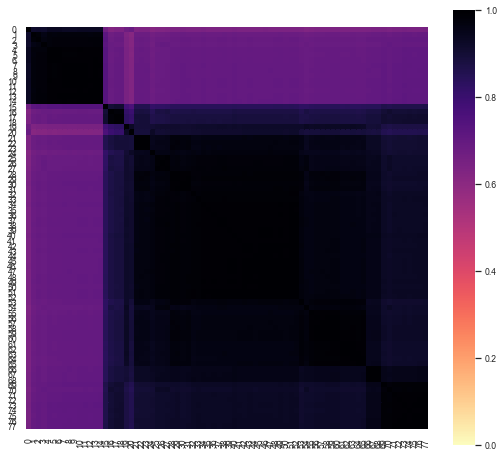

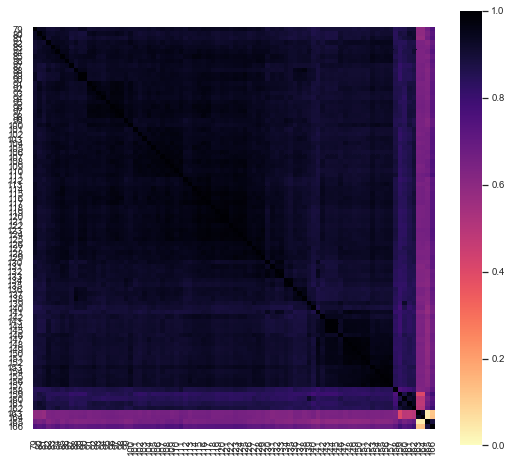

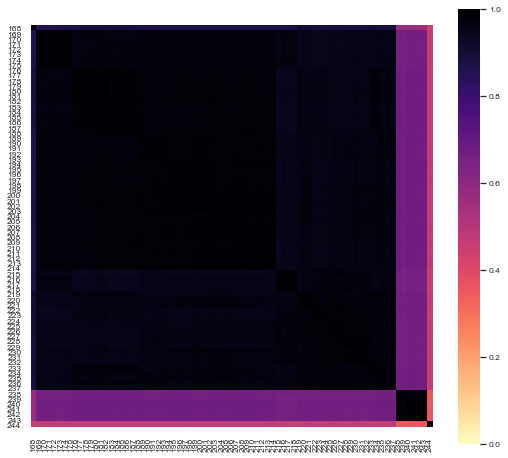

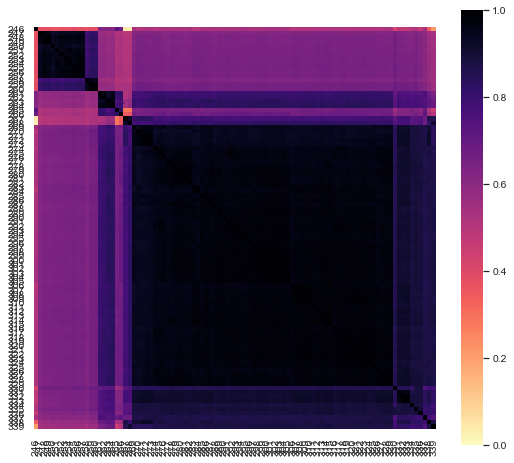

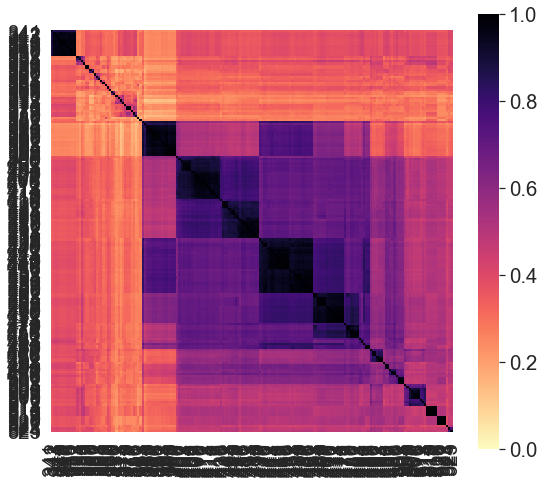

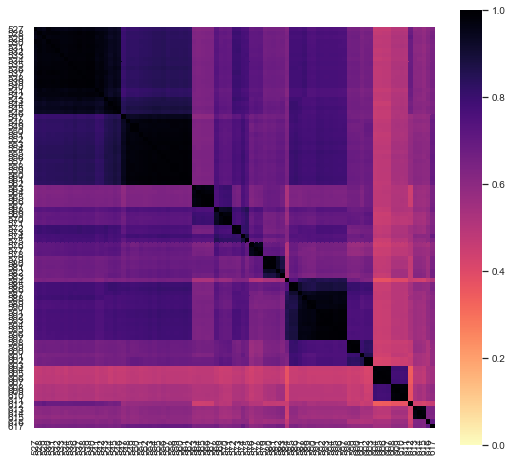

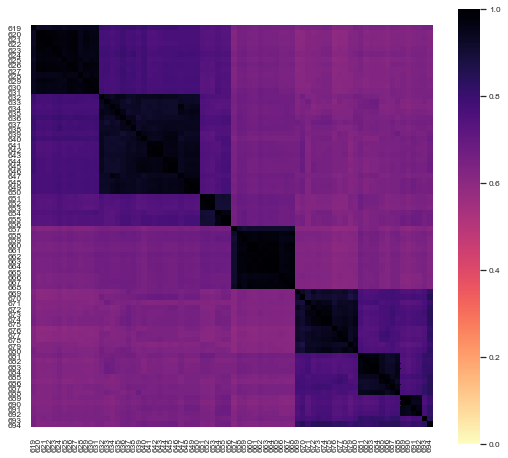

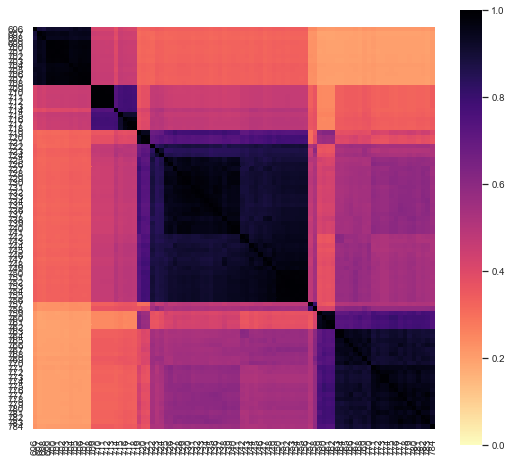

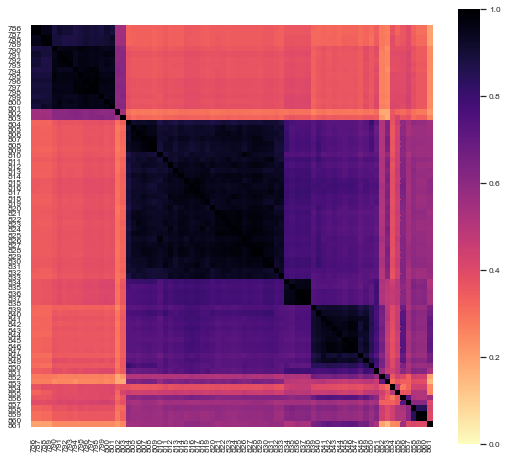

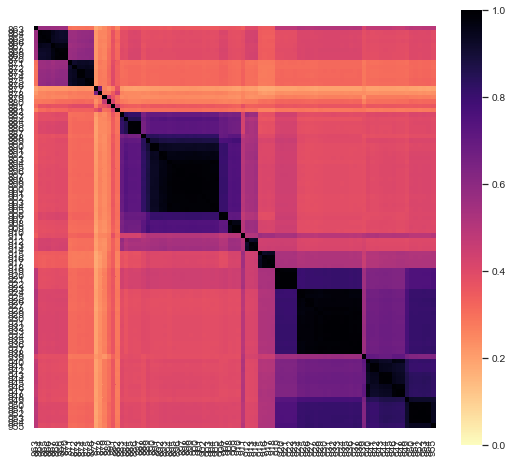

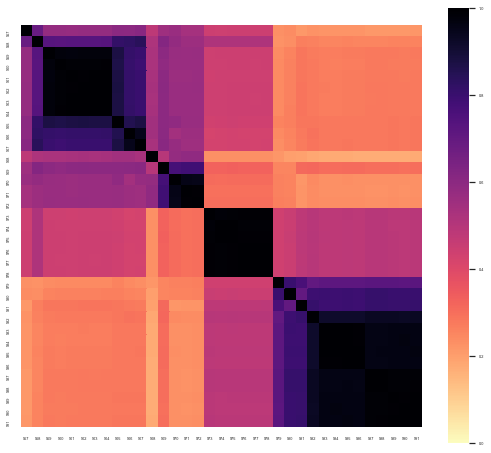

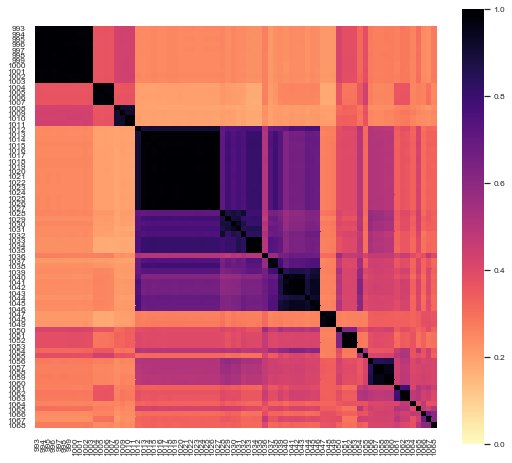

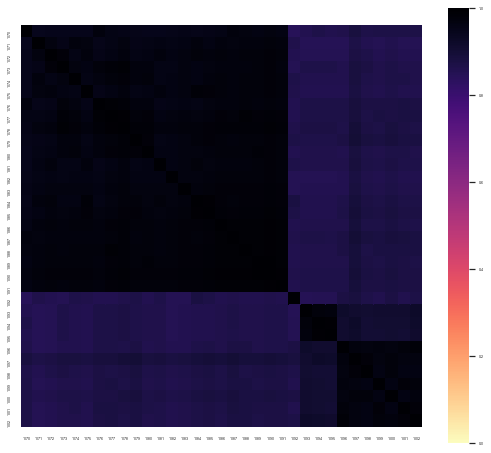

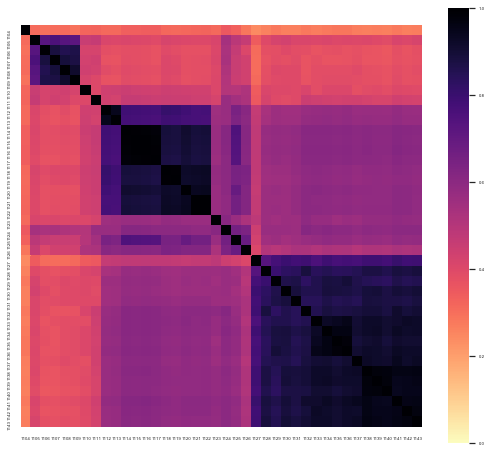

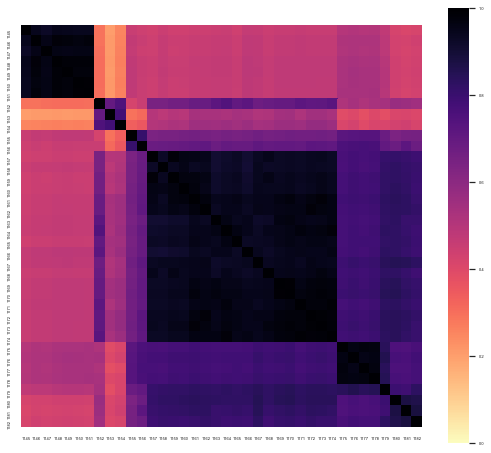

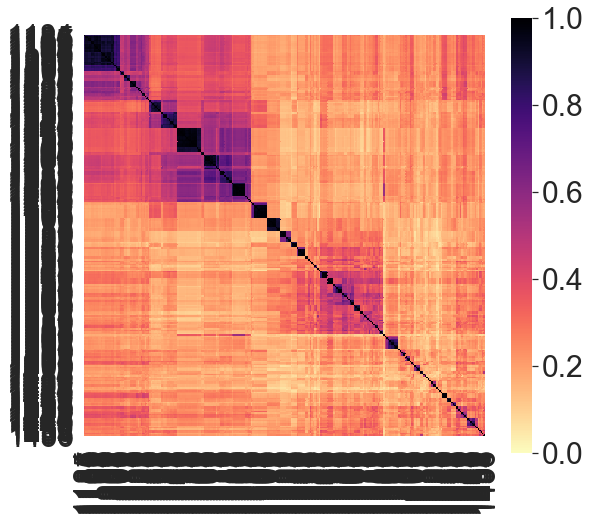

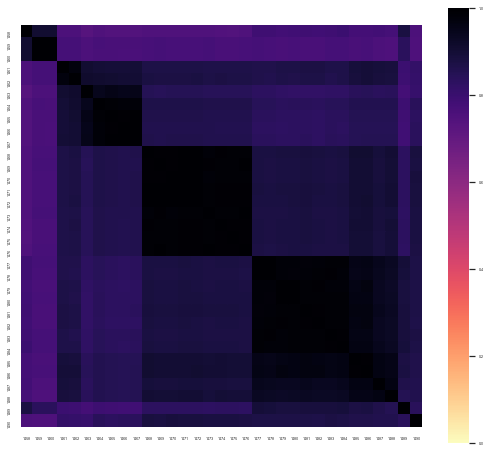

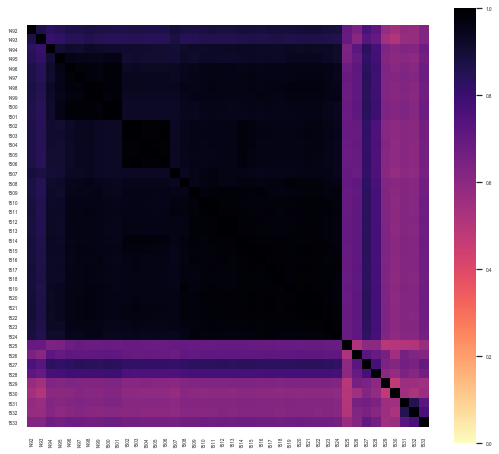

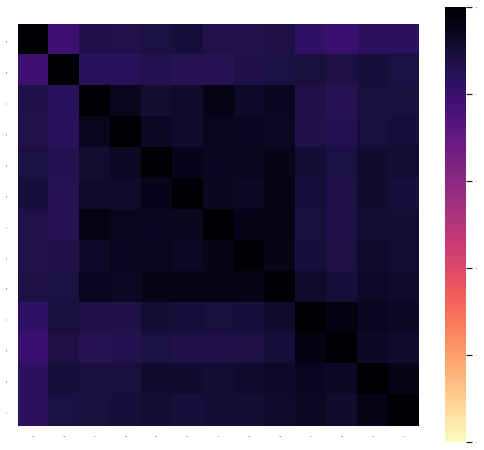

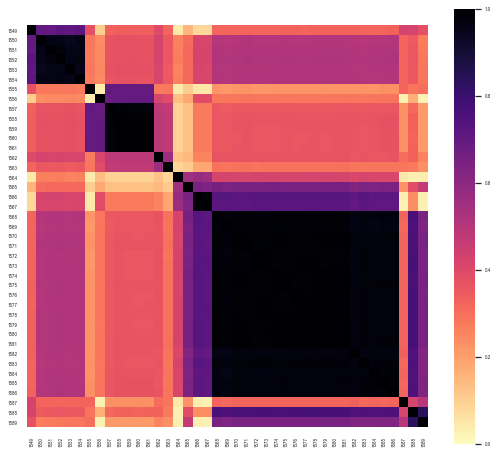

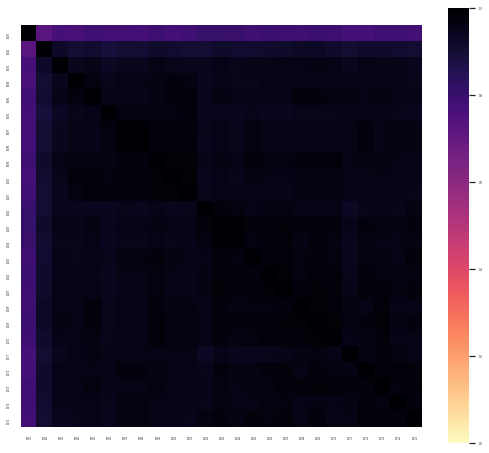

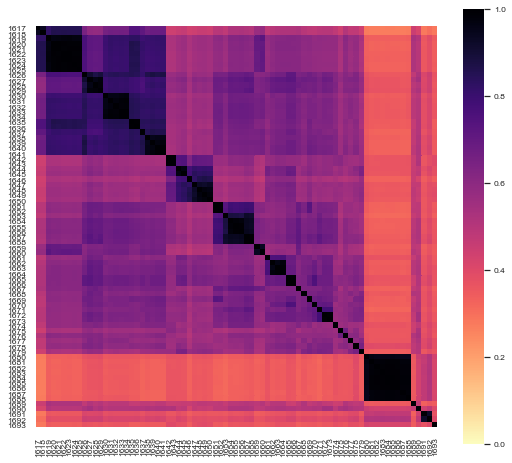

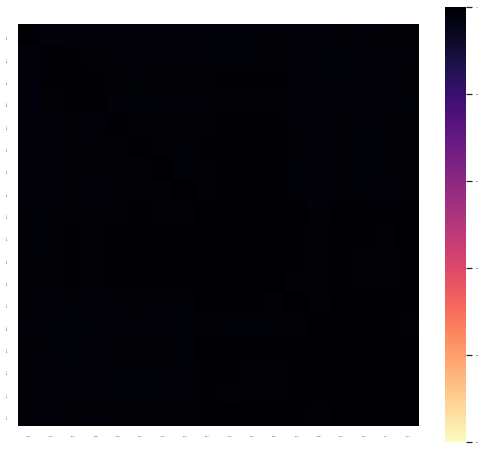

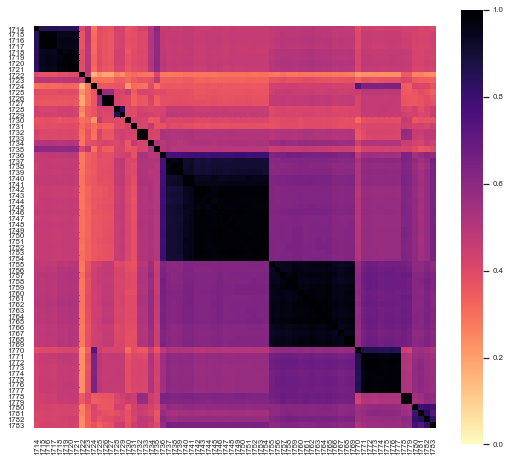

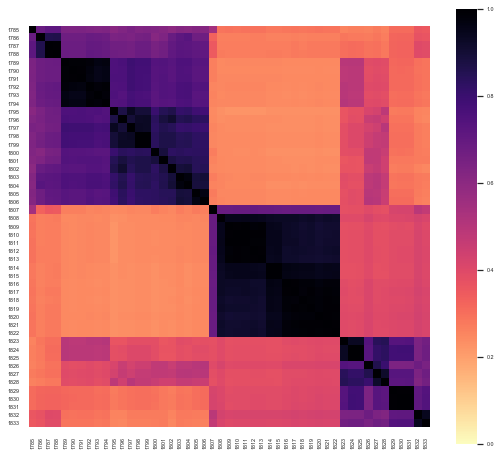

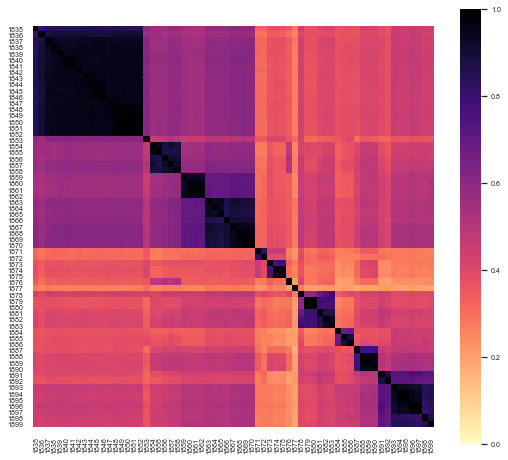

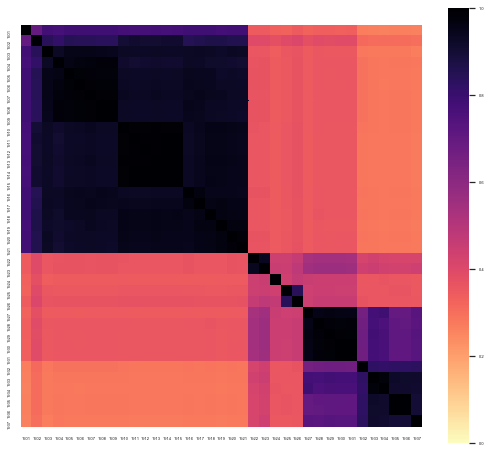

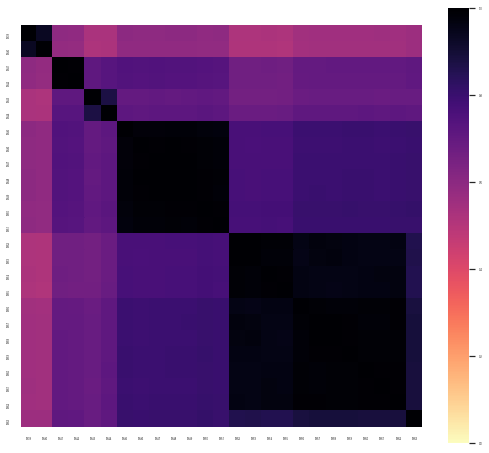

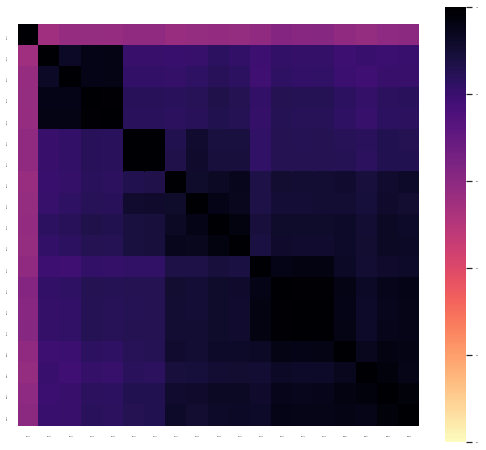

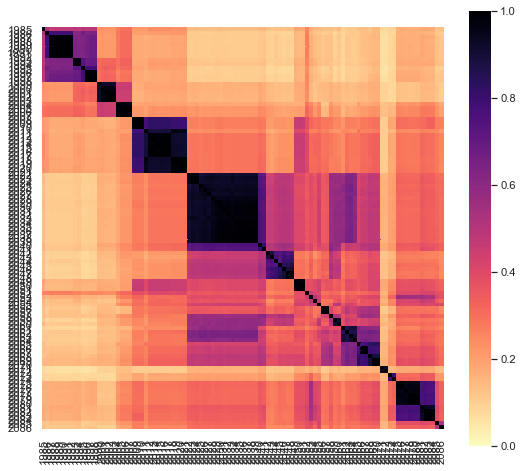

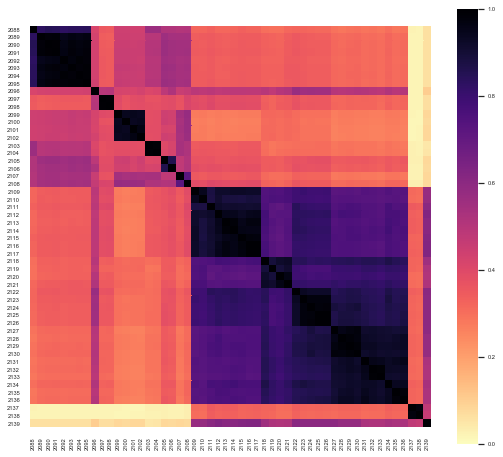

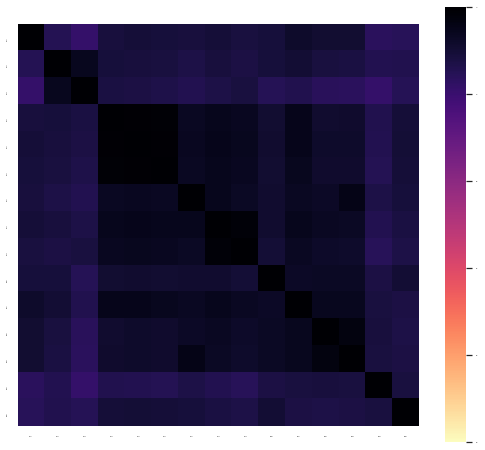

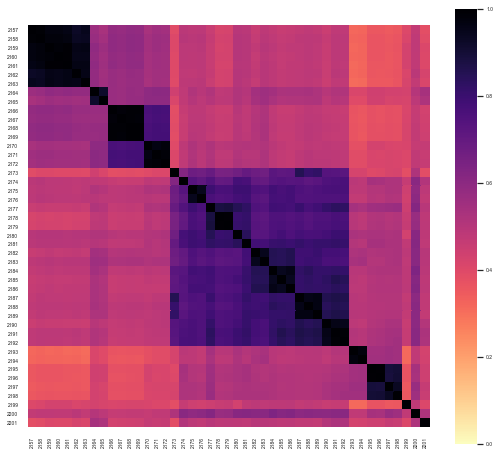

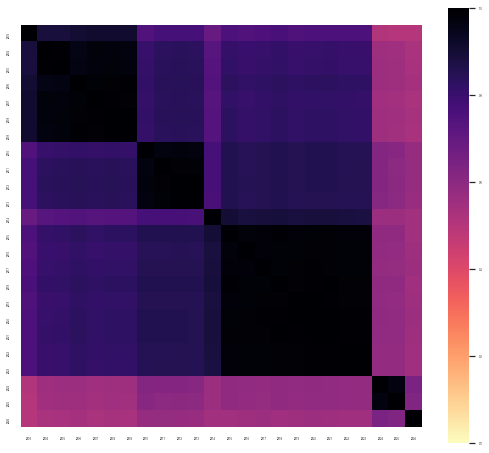

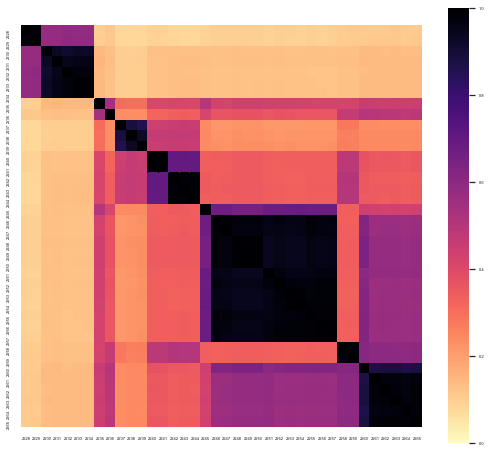

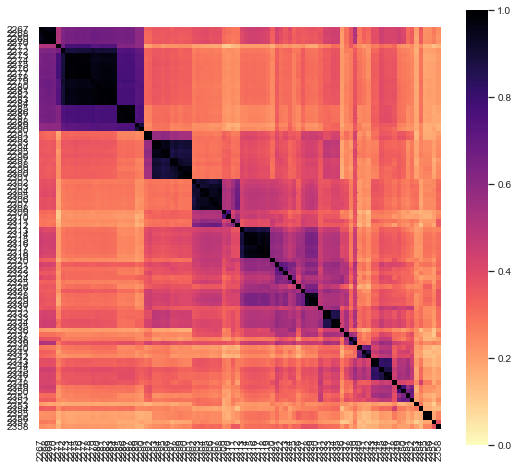

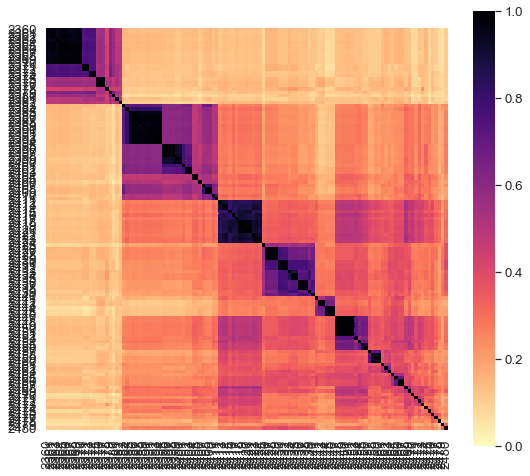

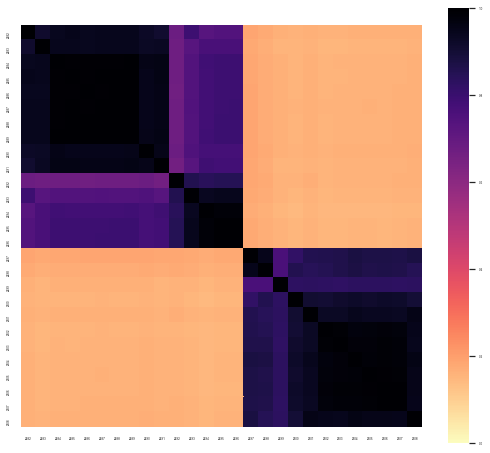

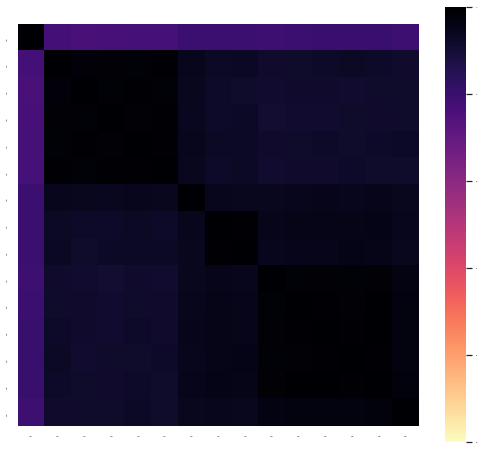

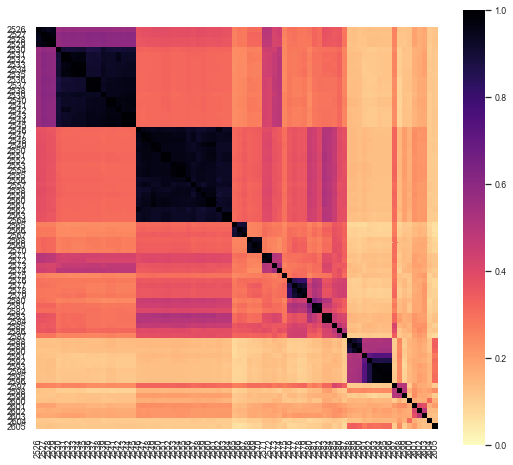

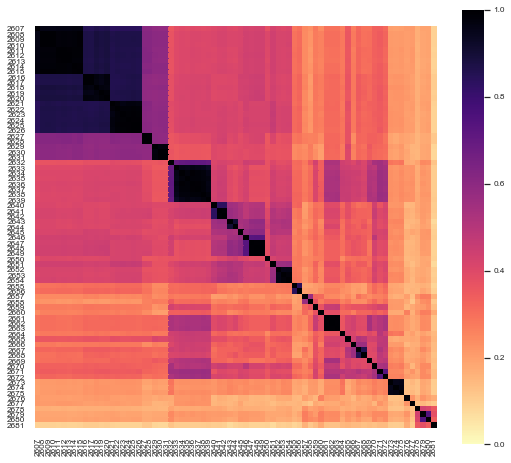

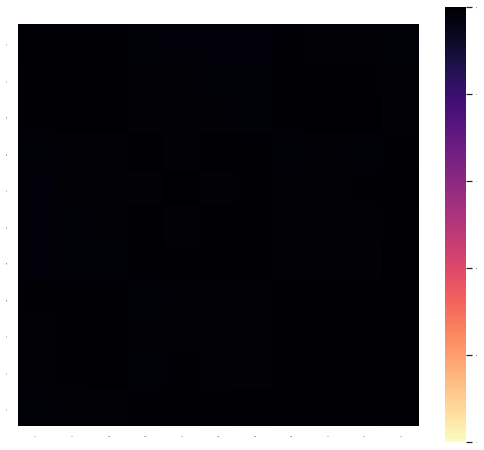

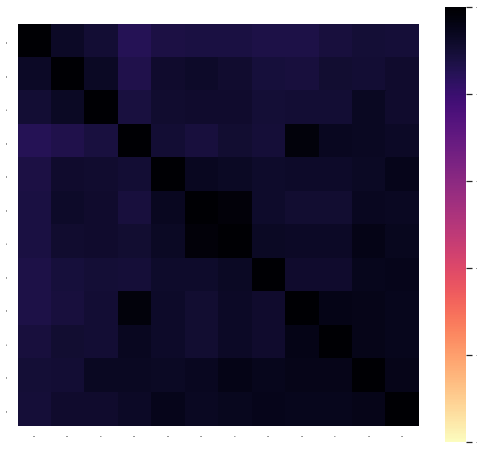

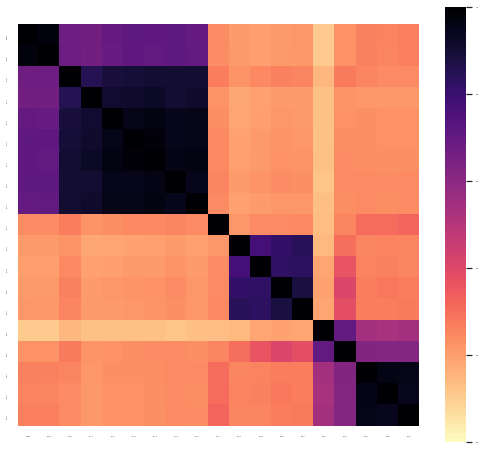

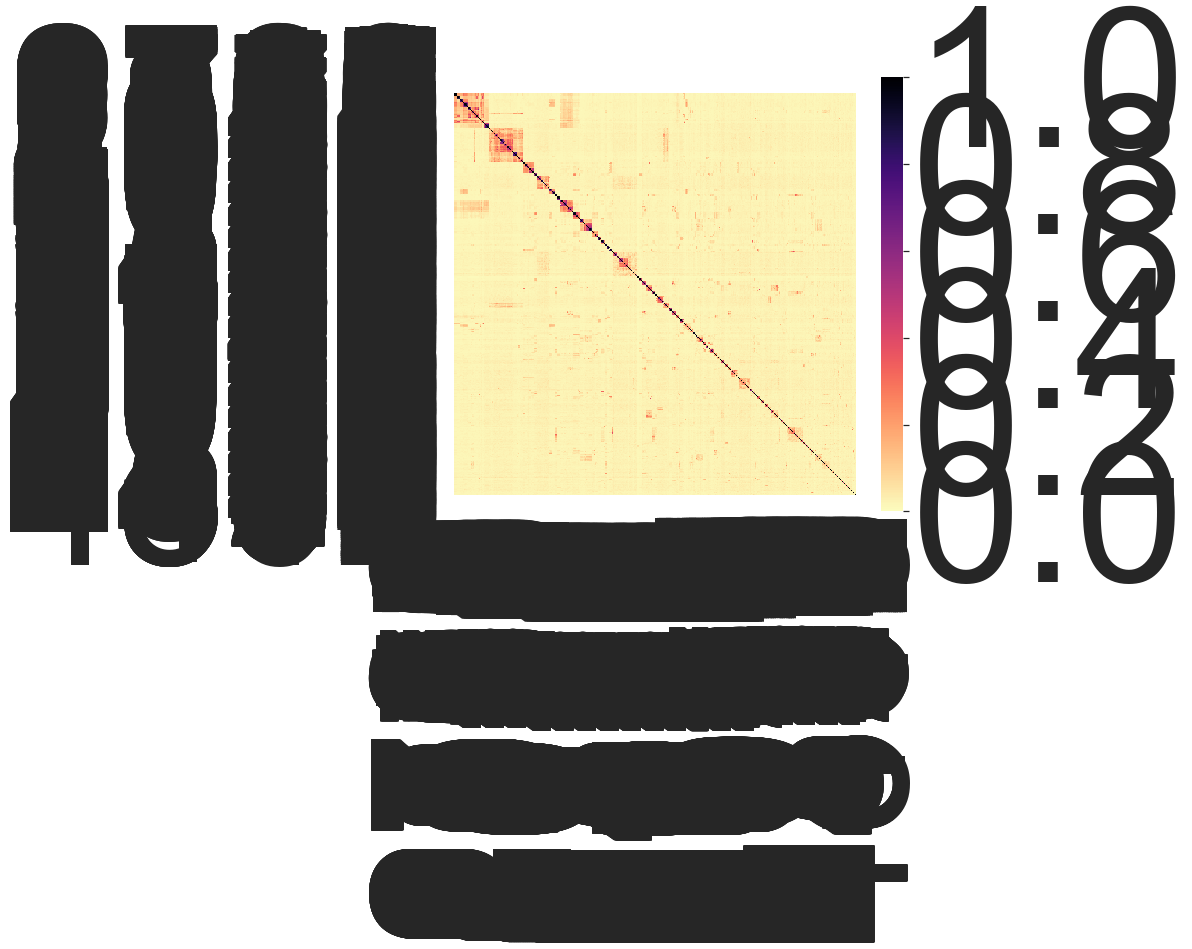

In [56]:
for i in np.arange(1, 46):
    cluster_writeout(i, 0.5, reordered_sim_df, row_linkage, accs_ordered, acc2doms, host_df)
    update_progress(i/46)
update_progress(1)